In [1]:
import os
from pathlib import Path

testfolder = os.path.join('TEMP','Tomato2020-TMY')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in TEMP\Tomato2020-TMY


In [2]:
from bifacial_radiance import *
import numpy as np
import pandas as pd
import datetime
import pvlib


In [3]:
# This information helps with debugging and getting support :)
import sys, platform
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)
print("PVLib version ", pvlib.__version__)

Working on a  Windows 10
Python version  3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.0
bifacial_radiance version  0.4.2+236.g6801d3d.dirty
PVLib version  0.10.4.dev9+ge92ee94


In [4]:
startdt = datetime.datetime(2001,3,15,0)
enddt = datetime.datetime(2001,6,30,23)

In [5]:
NREL_API_KEY = None  # <-- please set your NREL API key here
# note you must use "quotes" around your key as it is a string.

if NREL_API_KEY is None:
       NREL_API_KEY = 'DEMO_KEY'  # OK for this demo, but better to get your own key

In [6]:
#Site 3
lat_1=45.03395745800369
lon_1=-123.09725588548692


In [7]:
data2020_S3, metdata2020_S3 = pvlib.iotools.get_psm3(
    latitude=lat_1, longitude=lon_1,
    api_key=NREL_API_KEY,
    email='silvana.ovaitt@nrel.gov',  # <-- any email works here fine
    names='2020', map_variables=True, leap_day=False)

dataTMY_S3, metdataTMY_S3 = pvlib.iotools.get_psm3(
    latitude=lat_1, longitude=lon_1,
    api_key=NREL_API_KEY,
    email='silvana.ovaitt@nrel.gov',  # <-- any email works here fine
    names='tmy', map_variables=True, leap_day=False)


In [8]:
data2020_S3.to_csv('data2020_S3.csv')
dataTMY_S3.to_csv('dataTMY_S3.csv')

In [9]:
clearance_heights = [0.88, 0.9482582, 0.6985] # m
ygaps = [0.02, 0.02, 0.02] # m
cws = [3.3655, 3.3655, 3.9624] # m
rtrs = [6.223, 8.4201, 6.8453] # m
tilt = 25
sazm = 180
albedo = 0.2 # 'grass'
years=[2020,'TMY']
datasets_S3 = [data2020_S3, dataTMY_S3]
metdataset_S3 = [metdata2020_S3, metdataTMY_S3]

# Field size. Just going for 'steady state'
nMods = 20
nRows = 7

In [10]:
startdts = [datetime.datetime(2001,4,1,0),
            datetime.datetime(2001,5,1,0),
            datetime.datetime(2001,6,1,0),
            datetime.datetime(2001,7,1,0),
            datetime.datetime(2001,8,1,0),
            datetime.datetime(2001,9,1,0),
            datetime.datetime(2001,10,1,0),
            datetime.datetime(2001,4,1,0)]

enddts = [datetime.datetime(2001,4,30,23),
          datetime.datetime(2001,5,31,23),
          datetime.datetime(2001,6,30,23),
          datetime.datetime(2001,7,31,23),
          datetime.datetime(2001,8,31,23),
          datetime.datetime(2001,9,30,23),
          datetime.datetime(2001,10,15,0),
          datetime.datetime(2001,10,15,0)]


In [11]:
demo = RadianceObj('oregon', path=testfolder)
demo.setGround(0.2)

path = TEMP\Tomato2020-TMY
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.


## 2. Read and compile values

In [12]:
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [13]:
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

#sns.set(rc={'figure.figsize':(5.7,4.27)})

In [14]:
testfolder

'TEMP\\Tomato2020-TMY'

In [15]:
results_BGG=[]
results_GFront=[]
results_GRear=[]
results_GGround=[]
results_coordY=[]
setups = []

GHIs = []
year_strs = []
startm = []
endm = []

for setup in range(2, 3):
    for year in range(0, 2):
        for mmonth in range(0, len(startdts)):
                
            year_str = years[year]
            startdt = startdts[mmonth]
            enddt = enddts[mmonth]    
            
            weather = datasets_S3[year]
            meta = metdataset_S3[year]
            metdata = demo.NSRDBWeatherData(meta, weather,starttime=startdt, endtime=enddt, coerce_year=2001) # read in the EPW weather data from above
            GHIs.append(metdata.ghi.sum())
            
            # irr_GROUND_Month_6_setup_1_Row4_Module10_Back.csv
            fileground= os.path.join('results', f'irr_GROUND_setup_'+str(setup+1)+'_'+str(year_str)+'_'+str(startdt.month)+'to'+str(enddt.month)+'__Row4_Module10_Front.csv')
            filepv= os.path.join('results', f'irr_MODULE_setup_'+str(setup+1)+'_'+str(year_str)+'_'+str(startdt.month)+'to'+str(enddt.month)+'__Row4_Module10.csv')
            resultsGround = load.read1Result(fileground)
            resultsPV = load.read1Result(filepv)
            #  resultsDF = load.cleanResult(resultsDF).dropna() # I checked them they are good because even number of sensors
            results_GGround.append(list(resultsGround['Wm2Front']))
            results_coordY.append(list(resultsGround['y']))
            results_GFront.append(list(resultsPV['Wm2Front']))
            results_GRear.append(list(resultsPV['Wm2Back']))
            results_BGG.append(resultsPV['Wm2Back'].sum()*100/resultsPV['Wm2Front'].sum())
            
            year_strs.append(year_str)
            startm.append(startdt.month)
            endm.append(enddt.month)
            setups.append(setup+1)

8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact timestamp in input Weather File
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for center labeled data, at exact 

In [16]:
df = pd.DataFrame(list(zip(year_strs, setups, startm, endm, GHIs, results_coordY, results_GGround,
                          results_GFront, results_GRear, results_BGG)),
               columns =['Year', 'Setup', 'Start Month', 'End Month', 'GHI', 'GroundCoordY', 'Gground', 'Gfront', 'Grear', 'BGG'])

In [17]:
df[['BedA','BedB','BedC']] = pd.DataFrame(df.Gground.tolist(), index= df.index)

In [18]:
df.to_csv('Results_DF_tomato.csv')

In [19]:
# Example of selectiong one setup one month
df[(df['Setup']==3) & (df['Start Month']==5)]

,Year,Setup,Start Month,End Month,GHI,GroundCoordY,Gground,Gfront,Grear,BGG,BedA,BedB,BedC
1,2020,3,5,5,166729.0,"[2.257857, 3.217977, 4.178097]","[55365.0, 138731.1, 152266.7]","[163032.6, 164474.9, 166128.5, 166968.8, 16674...","[11672.36, 9239.116, 8156.147, 8590.354, 9098....",6.350012,55365.00,138731.1,152266.7
9,TMY,3,5,5,177573.0,"[2.257857, 3.217977, 4.178097]","[60798.12, 146415.8, 160521.6]","[172416.7, 173999.8, 175148.29999999996, 17610...","[12511.64, 10055.48, 9412.702, 9221.529, 9407....",6.413269,60798.12,146415.8,160521.6


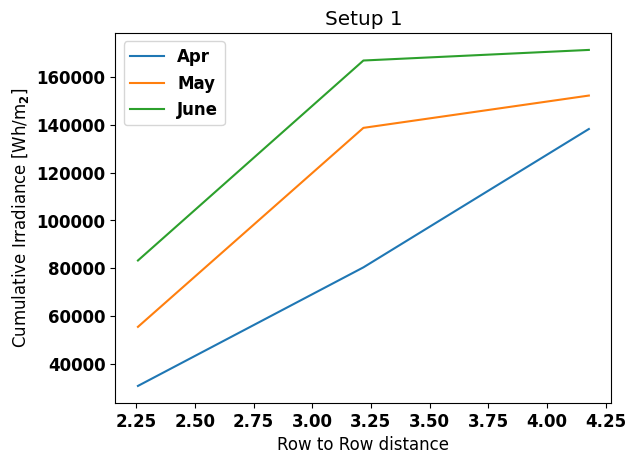

In [20]:
foo = df[(df['Setup']==3) & (df['Start Month']==4) & (df['End Month']==4)]
foo1 = df[(df['Setup']==3) & (df['Start Month']==5)]
foo2 = df[(df['Setup']==3) & (df['Start Month']==6)]

plt.plot(foo['GroundCoordY'][0], foo['Gground'].iloc[0], label='Apr')
plt.plot(foo['GroundCoordY'][0], foo1['Gground'].iloc[0], label='May')
plt.plot(foo['GroundCoordY'][0], foo2['Gground'].iloc[0], label='June')
plt.title('Setup 1')
plt.xlabel('Row to Row distance')
plt.ylabel('Cumulative Irradiance [Wh/m$_2$]')
plt.legend()

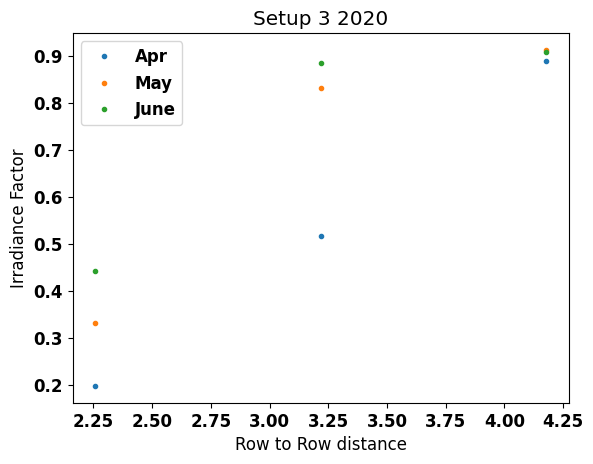

In [21]:
foo = df[(df['Setup']==3) & (df['Start Month']==4) & (df['End Month']==4)]
foo1 = df[(df['Setup']==3) & (df['Start Month']==5)]
foo2 = df[(df['Setup']==3) & (df['Start Month']==6)]

plt.plot(foo['GroundCoordY'][0], foo['Gground'].iloc[0]/foo['GHI'].iloc[0], '.', label='Apr')
plt.plot(foo['GroundCoordY'][0], foo1['Gground'].iloc[0]/foo1['GHI'].iloc[0], '.', label='May')
plt.plot(foo['GroundCoordY'][0], foo2['Gground'].iloc[0]/foo2['GHI'].iloc[0], '.', label='June')
plt.title('Setup 3 2020')
plt.xlabel('Row to Row distance')
plt.ylabel('Irradiance Factor')
plt.legend();

<Axes: >

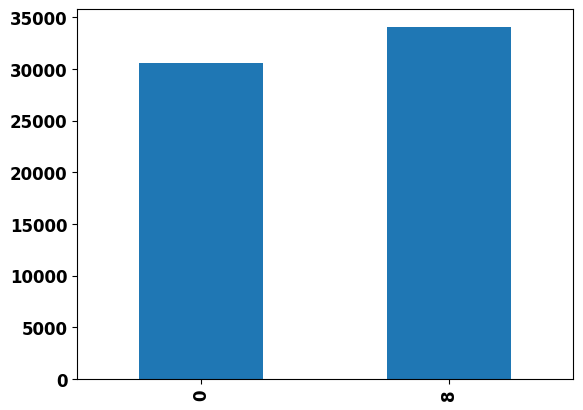

In [22]:
foo = df[(df['Setup']==3) & (df['Start Month']==4) & (df['End Month']==4)]
foo['BedA'].plot.bar()

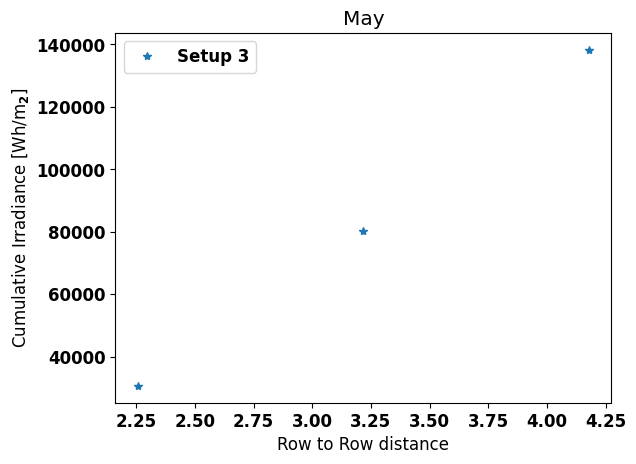

In [23]:
foo2 = df[(df['Setup']==3) & (df['Start Month']==4) & (df['End Month']==4)]

plt.plot(foo2['GroundCoordY'].iloc[0], foo2['Gground'].iloc[0], '*', label='Setup 3')
plt.title('May')
plt.xlabel('Row to Row distance')
plt.ylabel('Cumulative Irradiance [Wh/m$_2$]')
plt.legend();

# Weather Files PLOTTING

In [24]:
from matplotlib.dates import DateFormatter

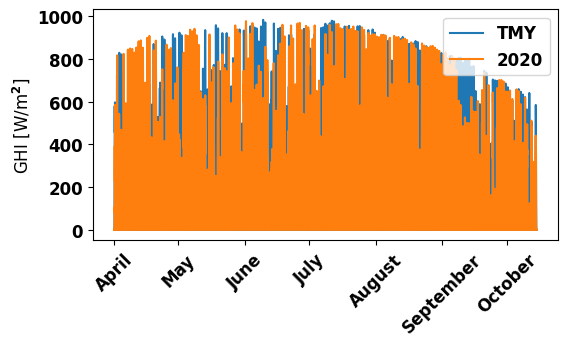

In [25]:
startdt = '2001-04-01 00:30:00-08:00'
enddt = '2001-10-15 00:30:00-08:00'
foo = dataTMY_S3[(dataTMY_S3.index>startdt)&(dataTMY_S3.index<enddt)]
foo2 = data2020_S3[(data2020_S3.index>startdt)&(data2020_S3.index<enddt)]#
#foo.index = foo.index.strftime('%m-%d %h')
#foo2.index = foo2.index.strftime('%m-%d %h')

fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(foo.GHI, label='TMY')
plt.plot(foo2.GHI, label='2020')
plt.xticks(rotation=45)
plt.legend()
plt.ylabel('GHI [W/m$^2$]')
# Define the date format
date_form = DateFormatter("%B")
ax.xaxis.set_major_formatter(date_form)
#ax.set_major_formatter(mdates.DateFormatter('%B'))